In [1]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq

# Dark Matter N-Body Simulation

This notebook provides a minimal framework for simulating the evolution of a dark matter particle distribution using a simple Particle-Mesh (PM) method and Leapfrog integration.

You will:
1. Initialize the simulation
2. Assign particles to a grid
3. Solve for gravitational forces using a PM gravity solver
4. Integrate particle positions using the leapfrog algorithm and the Kick-Drift-Kick scheme


### Step 1: Set up Initial conditions

In [ ]:
# Define parameters of simulations

# Simulation parameters
N = 256  # grid size
L = 100.0  # box size in Mpc/h
dx = L / N # length of one cell
Np = N**3  # number of particles
G = 1e-6 # Arbitrary units for gravitational constant
rho_crit=1.271e11 # Critical density in Msun/Mpc^3
Mp=Np/L**3*0.3*rho_crit # Mean particle mass in Msun
dt = 1  # time step in arbitrary units
nsteps = 5 # total steps (feel free to adjust!)

In [ ]:
# Function for creating Gaussian displacements of particles based on a power spectrum
# Helper function here, no TODO, but check how it works!

def generate_gaussian_displacement(N, L, power_index=-2, amplitude=1.0, seed=42):
    """Function to create initial Gaussian displacement of particles

    Args:
        N (int): Number of grid points
        L (float): Side length of box
        power_index (int, optional): Index of initial powerspectrum. Defaults to -2.
        amplitude (float, optional): Amplitude of fluctuations. Defaults to 1.0.
        seed (int, optional): Random seed. Defaults to 42.

    Returns:
        np.ndarray: particle displacements
    """
    np.random.seed(seed)
    dx = L / N
    k = fftfreq(N, d=dx) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
    k_squared = kx**2 + ky**2 + kz**2
    k_squared[0, 0, 0] = 1.0  # avoid division by zero at k=0

    # Generate complex Gaussian random field in Fourier space
    random_field = (
        np.random.normal(size=(N, N, N)) +
        1j * np.random.normal(size=(N, N, N))
    )

    # Define a simple power spectrum: P(k) ∝ k^power_index
    P_k = k_squared**(power_index / 2.0)
    P_k[k_squared == 0] = 0  # zero mode has no power
    field_k = random_field * np.sqrt(P_k)

    # Displacement = gradient of potential ⇒ multiply by i k / k^2 in Fourier space
    disp_x = np.real(ifftn(1j * kx * field_k / k_squared))
    disp_y = np.real(ifftn(1j * ky * field_k / k_squared))
    disp_z = np.real(ifftn(1j * kz * field_k / k_squared))
    
    displacement = np.stack([disp_x, disp_y, disp_z], axis=-1)
    displacement *= amplitude  # scale the displacement

    return displacement


In [ ]:
# Initial grid positions

# Create initial grid positions
# TODO: Set particles on grid points. Remember the periodic boundary condition!
x = ...


# Generate Gaussian displacement field
# TODO: Create Gaussian displacement field
displacement_field = ...

# Interpolate displacement from grid to particle positions (nearest grid point)
ix = (x / dx).astype(int) % N
displacement = displacement_field[ix[:, 0], ix[:, 1], ix[:, 2]]

# Apply displacement to particle positions
# TODO: Add particle positions and displacement
x = ...

# Set initial velocity to zero
# TODO: Set velocity to zero
v= ...

### Step 2: Assign particles to mesh
We assign particles to a mesh.

In [ ]:
def create_density_grid(positions, N, L):
    """
    Create a density grid (delta) using nearest grid point interpolation.

    Parameters:
    positions (numpy.ndarray): Array of 3D positions of shape (num_points, 3).
    N (int): Number of grid points along each axis.
    L (float): Side length of the box.

    Returns:
    numpy.ndarray: A 3D grid of shape (N, N, N) with the values of delta.
    """

    #TODO: Fill this function


    return density_grid

### Step 3: Gravity solver
We solve the Poisson equation using FFT. We use that the acceleration is given by
$$ \mathbf{a} = \nabla \Phi $$
so in Fourier space we can use
$$ \hat{\mathbf{a}} = \mathbf{k} \hat{\Phi}

In [ ]:
# Solve Poisson equation and compute acceleration field
def compute_acceleration(delta):

    # Create mesh of k-values
    k = fftfreq(N, d=dx) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    k2[0, 0, 0] = 1  # avoid division by zero

    # Fourier transform delta and solve the Poisson equation for Phi_k
    # TODO: Calculate phi_k

    phi_k = ...

    # Get the acceleration a
    # TODO: Calculate ax, ay, az
    ax = ...
    ay = ...
    az = ...

    return np.stack([ax, ay, az], axis=-1)

### Step 4: Leapfrog Integrator
Now we use the Kick-Drift-Kick scheme to calculate the velocities and positions of particles at different time steps

In [ ]:
rhos=[]

# Leapfrog integrator
for step in range(nsteps):
    print(f"Calculating step {step} of {nsteps}")
    # Create density field
    # TODO: Create density field from current x-positions
    delta = ...

    # Compute acceleration
    # TODO: Create acceleration field from density field
    a_field = ...
    
    # Interpolate acceleration to particle positions (nearest-grid-point)
    acc = np.array([a_field[int(i[0])%N, int(i[1])%N, int(i[2])%N] for i in x / dx])
    
    # Kick-Drift-Kick
    
    # TODO: Calculate velocity and new x-position and new delta field with kick-drift-kick scheme. Remember the periodic boundary condition!
    v =...
    x=...
    delta=...

    # Save density field of this position to array rhos
    rhos.append(delta)


### Step 5: Visualization

We now plot the histograms of the density distribution for all timesteps. How does the distribution evolve?

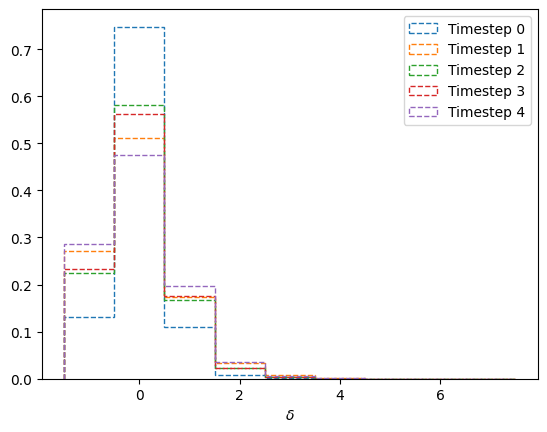

In [10]:
for i, rho in enumerate(rhos):
    plt.hist(rho.flatten(), label=f'Timestep {i}', histtype='step', ls='--', density=True, bins=(-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5))

plt.xlabel(r'$\delta$')
plt.legend()

### Step 6: (Optional)

Implement a friends-of-friends halo finder and check how the number of halos evolves with time and depending on the linking length you choose.